# LAPD lab - Machine learning project

This project aims to predict the GHI two hours in advance locally, from meteo data, date data and webcam images.

We are providing a machine learning model to achieve this task.

## Environnement and dataset definition

### Libraries

First, we import all important packages, data, and set the seed (for torch).


In [1]:
#importing packages
import numpy as np
import pandas as pd
import time
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn import preprocessing
from sklearn.linear_model import Ridge, ElasticNet, LinearRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import KFold
import math
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import h5py
import sys
import datetime
import math
import random
import itertools

%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torch.utils.data.sampler import SequentialSampler
from torchvision import transforms, utils

from datetime import datetime

from google.colab import files ### file.download() to download a file from colab instead of right clicking

### Seed definition

In an attempt for reproducibility, we define a torch seed for random processes.

In [2]:
# Set fixed random number seed
torch.manual_seed(3174)

### Mounting the drive
You may need to adjust the path according to your needs.

In [2]:
#Mounting Drive
from google.colab import drive
# # # # This will prompt for authorization.
drive.mount("/content/drive")

## change path to where the folder of the images is
path = 'drive/MyDrive/Colab Notebooks/CSS 433/data' #antonin
#path = 'drive/MyDrive/master/CSS 433/data' #Jade
#path = 'drive/MyDrive/data' #Jade ordi 2
#path = 'drive/MyDrive/CSS 433/data' #Alison

for file in os.listdir(path):
  print(file)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time.npy
new_irradiance.xlsx
persistent_level.npy
ground_truth.npy
labels.npy
meteo.xlsx
X.npy
meteo_time_raw.xlsx
iraddiance_raw.xlsx


### Creation of the Dataset

This class allows us to load the dataset and access each element individually.

#### GHIDataset

In [59]:
class GHIDataset(Dataset):
    """GHI dataset."""

    def __init__(self, root_dir, labels, images, meteo, GHI, time, transform_images=None, transform_label=None, normalise_meteo=False):
        """
        Arguments:
            root_dir  (string) : Path to folder with all the files.
            labels    (string) : Name of the file with labels.
            images    (string) : Name of the file with images.
            meteo     (string) : Name of the file with the meteo data
            GHI       (string) : Name of the file with the GHI (ground truth)
            time      (string) : Name of the file with the time at which the data (meteo and images) has been acquired
            transform_images (callable, optional): Optional transform to be applied to the images.
            transform_label  (callable, optional): Optional transform to be applied to the label.
            transform_meteo  (bool, optional)    : Optional normalisation to be applied to the meteo data.
        """


        self.root_dir = root_dir
        self.labels = torch.from_numpy(np.load(os.path.join(self.root_dir,labels))).to(torch.float32)
        self.images = np.load(os.path.join(self.root_dir,images),mmap_mode='c')

        # Define the transforms to apply to labels or input
        self.transform_images = transform_images
        self.transform_label = transform_label
        self.normalise_meteo = normalise_meteo

        self.GHI =  torch.from_numpy(np.load(os.path.join(path, GHI),allow_pickle=True)).to(torch.float32)

        df = pd.read_excel(os.path.join(self.root_dir, meteo))

        time_image = np.load(os.path.join(self.root_dir, time),allow_pickle=True)

        # Extract day, month, and year using list comprehension
        date = [(dt.day, dt.month, dt.year, dt.hour, dt.minute) if isinstance(dt, datetime) else
         (datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').day,
          datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').month,
          datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').year,
          datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').hour,
          datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').minute)
         for dt in time_image]

        # Transpose the list of tuples using zip
        day_, month_, year_, hour_, minute_ = zip(*date)

        # Convert the individual columns to PyTorch tensors and normalise if required
        if normalise_meteo:
          self.day = torch.tensor(preprocessing.normalize([day_])[0])
          self.month = torch.tensor(preprocessing.normalize([month_])[0])
          self.year = torch.tensor(preprocessing.normalize([year_])[0])
          self.hour = torch.tensor(preprocessing.normalize([hour_])[0])
          self.minute = torch.tensor(preprocessing.normalize([minute_])[0])
          self.air_temp = torch.from_numpy(preprocessing.normalize([df['Air_temp'].values])[0])
          self.wind_speed = torch.from_numpy(preprocessing.normalize([df['Wind_speed'].values])[0])
          self.wind_dir = torch.from_numpy(preprocessing.normalize([df['Wind_dir'].values])[0])
        else:
          self.day = torch.tensor(day_)
          self.month = torch.tensor(month_)
          self.year = torch.tensor(year_)
          self.hour = torch.tensor(hour_)
          self.minute = torch.tensor(minute_)
          self.air_temp = torch.from_numpy(df['Air_temp'].values)
          self.wind_speed = torch.from_numpy(df['Wind_speed'].values)
          self.wind_dir = torch.from_numpy(df['Wind_dir'].values)

    def __len__(self):
        return self.labels.size()[0]

    def __getitem__(self, idx):
        """
        Arguments:
            idx (list or torch.Tensor) : list of two dimension indicating which sample
                                         to get and which webcam.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Import from memory only the data (images, meteo, GHI and time) that we want
        image0 = np.array(self.images[idx,0])
        image1 = np.array(self.images[idx,1])
        labels = self.labels[idx]

        GHI = self.GHI[idx]
        day = self.day[idx]
        month = self.month[idx]
        year = self.year[idx]
        hour = self.hour[idx]
        minute = self.minute[idx]
        air_temp = self.air_temp[idx]
        wind_speed = self.wind_speed[idx]
        wind_dir = self.wind_dir[idx]

        meteo_data = torch.stack((day, month, year, hour, minute, GHI, air_temp, wind_speed, wind_dir)).to(torch.float32)

        # Apply the transforms
        if self.transform_images:
            image0 = self.transform_images(image0)
            image1 = self.transform_images(image1)

        if self.transform_label:
            labels = self.transform_label(labels)

        return image0,image1,meteo_data,labels

#### GHIDataset 2

This dataset allows to retrieve multiple indices at once, hence allowing to load consecutive samples.

In [122]:
class GHIDataset2(Dataset):
    """GHI dataset."""

    def __init__(self, root_dir, labels, images, meteo, GHI, time, transform_images=None, transform_label=None, normalise_meteo=False):
        """
        Arguments:
            root_dir  (string) : Path to folder with all the files.
            labels    (string) : Name of the file with labels.
            images    (string) : Name of the file with images.
            meteo     (string) : Name of the file with the meteo data
            GHI       (string) : Name of the file with the GHI (ground truth)
            time      (string) : Name of the file with the time at which the data (meteo and images) has been acquired
            transform_images (callable, optional): Optional transform to be applied to the images.
            transform_label  (callable, optional): Optional transform to be applied to the label.
            transform_meteo  (bool, optional)    : Optional normalisation to be applied to the meteo data.
        """


        self.root_dir = root_dir
        self.labels = torch.from_numpy(np.load(os.path.join(self.root_dir,labels))).to(torch.float32)
        self.images = np.load(os.path.join(self.root_dir,images),mmap_mode='c')

        # Define the transforms to apply to labels or input
        self.transform_images = transform_images
        self.transform_label = transform_label
        self.normalise_meteo = normalise_meteo

        self.GHI =  torch.from_numpy(np.load(os.path.join(path, GHI),allow_pickle=True)).to(torch.float32)

        df = pd.read_excel(os.path.join(self.root_dir, meteo))

        time_image = np.load(os.path.join(self.root_dir, time),allow_pickle=True)

        # Extract day, month, and year using list comprehension
        date = [(dt.day, dt.month, dt.year, dt.hour, dt.minute) if isinstance(dt, datetime) else
         (datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').day,
          datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').month,
          datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').year,
          datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').hour,
          datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').minute)
         for dt in time_image]

        # Transpose the list of tuples using zip
        day_, month_, year_, hour_, minute_ = zip(*date)

        # Convert the individual columns to PyTorch tensors and normalise if required
        if normalise_meteo:
          self.day = torch.tensor(preprocessing.normalize([day_])[0])
          self.month = torch.tensor(preprocessing.normalize([month_])[0])
          self.year = torch.tensor(preprocessing.normalize([year_])[0])
          self.hour = torch.tensor(preprocessing.normalize([hour_])[0])
          self.minute = torch.tensor(preprocessing.normalize([minute_])[0])
          self.air_temp = torch.from_numpy(preprocessing.normalize([df['Air_temp'].values])[0])
          self.wind_speed = torch.from_numpy(preprocessing.normalize([df['Wind_speed'].values])[0])
          self.wind_dir = torch.from_numpy(preprocessing.normalize([df['Wind_dir'].values])[0])
        else:
          self.day = torch.tensor(day_)
          self.month = torch.tensor(month_)
          self.year = torch.tensor(year_)
          self.hour = torch.tensor(hour_)
          self.minute = torch.tensor(minute_)
          self.air_temp = torch.from_numpy(df['Air_temp'].values)
          self.wind_speed = torch.from_numpy(df['Wind_speed'].values)
          self.wind_dir = torch.from_numpy(df['Wind_dir'].values)

    def __len__(self):
        return self.labels.size()[0]

    def __getitem__(self, idx):
        """
        Arguments:
            idx (list or torch.Tensor) : list of two dimension indicating which sample
                                         to get and which webcam.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Import from memory only the data (images, meteo, GHI and time) that we want
        image0 = np.array(self.images[idx,0])
        image1 = np.array(self.images[idx,1])
        labels = self.labels[idx]

        GHI = self.GHI[idx]
        day = self.day[idx]
        month = self.month[idx]
        year = self.year[idx]
        hour = self.hour[idx]
        minute = self.minute[idx]
        air_temp = self.air_temp[idx]
        wind_speed = self.wind_speed[idx]
        wind_dir = self.wind_dir[idx]

        meteo_data = torch.stack((day, month, year, hour, minute, GHI, air_temp, wind_speed, wind_dir),dim=1).to(torch.float32)

        # Apply the transforms
        if self.transform_images:
          image0_transformed = []
          image1_transformed = []
          for image in image0:
            image0_transformed.append(self.transform_images(image))
          for image in image1:
            image1_transformed.append(self.transform_images(image))

        if self.transform_label:
            labels = self.transform_label(labels)

        data = (torch.stack(image0_transformed),torch.stack(image1_transformed),meteo_data,labels)

        return data

Below we load the dataset and transfom the images.

#### Dataset Creation

In [123]:
# Set the desired size of the image
img_size = 100

# The following line creates a transform which converts the np.array to a PIL Image.
# It then resizes the image to img_size x img_size and converts the image to a tensor

transform = transforms.Compose([transforms.ToPILImage(),transforms.Resize(img_size),transforms.ToTensor()])

# Generate the dataset containing all the samples
#ghi_dataset = GHIDataset(path,'labels.npy','X.npy','meteo.xlsx','ground_truth.npy','time.npy',transform)
ghi_dataset = GHIDataset2(path,'labels.npy','X.npy','meteo.xlsx','ground_truth.npy','time.npy',transform)

### Data Separation

The data need to be split between train and test set.

Here we define a function to split the dataset into a test set, a validation set and a train set.

We also define a function to split the dataset in a given site to choose the test set we want.

Note that we do not shuffle the data as it is time dependent. What is significant here is that we test for the last values of the set.


#### Separation Functions

In [55]:
def split_at_location(dataset, location = 0, length = 100):
    """
      This function allows to extract the test or validation set at a given location in the dataset
        Arguments:
            location  (int) : position in the dataset where the test/validation set will start
            length    (int) : length of the test/validation set
        """
    # Initialise the indices of the dataset
    dataset_idx = np.arange(len(dataset))
    # Compute start and stop indices of the test/validation set while preventing out-of-range targets
    start_idx = max(0,location)
    end_idx = min(len(dataset),location+length)
    validation_idx = dataset_idx[start_idx:end_idx]

    # Compute the indices of the training set by removing the ones of the test/validation set.
    train_idx = np.concatenate([dataset_idx[:start_idx], dataset_idx[end_idx:]])

    # Return the two sets
    return Subset(dataset, train_idx), Subset(dataset, validation_idx)

def train_val_dataset(dataset,test_split=0.8, val_split=0.2):
    """
      split dataset in train set, validation set, test set
    """

    test_idx, train_idx = train_test_split(list(range(len(dataset))), test_size=test_split,shuffle=False)
    train_idx, val_idx = train_test_split(train_idx,test_size=val_split,shuffle=False)

    return Subset(dataset, train_idx), Subset(dataset, val_idx), Subset(dataset, test_idx)

def shuffle(dataset) :
  """
      This function allows to shuffle the data in the given set
  """

  data_idx = np.arange(len(dataset))
  random.shuffle(data_idx)
  #print(data_idx)
  return Subset(dataset, data_idx)


#### Choose our validation set

In [127]:
location = 1270

ghi_train, ghi_test = split_at_location(ghi_dataset, location, 400)

print("Train set of size      : ", len(ghi_train))
print("Validation set of size : ",len(ghi_test))

# below : in case of only one validation set, no cross validation

#ghi_train ,ghi_val= split_at_location(ghi_train, 0, round(len(ghi_train)*0.10))

#define the loader !
#train_loader = DataLoader(ghi_train, batch_sampler=SequentialBatchSampler(np.arange(len(ghi_train)), batch_size=32, dec = 32))
#test_loader = DataLoader(ghi_test, batch_sampler=SequentialBatchSampler(np.arange(len(ghi_test)), batch_size=32, dec = 32))


Train set of size      :  10293
Validation set of size :  400


## Definition of dataloaders

Finally we create the dataloader, to iterate on it as we compute each epoch.

We define a custom batch sampler because we need to conserve the order of the samples in each batch. Moreover, we want the stride (dec) between each batch to be customizable and not the batch size. Such that for a dataset = [1,2,3,4,5,6] and a batch size of 3 we get [1,2,3], [2,3,4], [3,4,5], [4,5,6] as batches

#### Sequencer 1

In [41]:
class SequentialBatchSampler:
    def __init__(self, data_source, batch_size, dec):
        self.data_source = data_source
        self.batch_size = batch_size
        self.dec = dec

    def __iter__(self):
      i = 0
      while i <= len(self.data_source)-self.batch_size-1:
        print(self.data_source[i:i+self.batch_size].dtype)
        yield self.data_source[i:i+self.batch_size]
        i += self.dec

#### Sequencer 2

In [46]:
class SequentialBatchSampler2:
    def __init__(self, data_source, batch_size, L):
        self.data_source = data_source
        self.batch_size = batch_size
        self.L = L

    def __iter__(self):
      i = 0
      indices = np.arange(len(self.data_source)-self.L)
      np.random.shuffle(indices)
      batch = []
      for idx in indices:
        sample = self.data_source[idx:idx+self.L]
        batch.append(sample)
        if len(batch) == self.batch_size:
          yield batch
          batch = []

## Model

we defined and tested several models for our purpose.

- Only taking in account the images, convolutionnal layer + LSTM
- Taking in account the images and meteo data (not implemented yet)
- Transformer (not implemented yet)

This neural network will take in account meteo data.

### Network Definition

In [179]:
class Net2(nn.Module):

    def __init__(self, dropout1 = 0.3, dropout2 = 0.1, out_channels=16, kernel_size1=3, kernel_size2=2, kernel_size3 = 3):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(6, out_channels, kernel_size = kernel_size1,stride=1) # input channels to 6 because 2 images ! (RGBx2)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = kernel_size1,stride=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.pool1 = nn.MaxPool2d(kernel_size2)
        self.drop1 = nn.Dropout2d(p=dropout1)
        self.conv3 = nn.Conv2d(out_channels, 2*out_channels, kernel_size = kernel_size3, stride=1)
        self.bn3 = nn.BatchNorm2d(2*out_channels)
        self.conv4 = nn.Conv2d(2*out_channels, 2*out_channels, kernel_size =kernel_size3,stride=1)
        self.bn4 = nn.BatchNorm2d(2*out_channels)
        self.pool2 = nn.MaxPool2d(kernel_size2)
        self.drop2 = nn.Dropout2d(p=dropout2)
        #self.linear_layer = nn.Linear(5, 32*22*22)  # 5 is the number of additional features
        self.lstm1 = nn.LSTM(2*out_channels* 22* 22, 8*out_channels, batch_first=True,num_layers=2)
        self.lstm2 = nn.LSTM(8*out_channels, 4*out_channels, batch_first=True)
        self.fc1 = nn.Linear(4*out_channels, 4*out_channels)
        self.fc2 = nn.Linear(4*out_channels*2, 1)

        # Skip connections
        self.skip_conv1 = nn.Conv2d(6, 32, kernel_size=1)  # Adjust channels as needed
        self.skip_conv2 = nn.Conv2d(32, 32, kernel_size=1)  # Adjust channels as needed

        # Additional features processing
        self.additional_fc1 = nn.Linear(9, 4*out_channels)  # Adjust input size and output size
        self.additional_fc2 = nn.Linear(4*out_channels, 4*out_channels)  # Adjust output size


    def forward(self, x1,x2,meteo_data): #x1 and x2 correspond to the 2 images
        x = torch.cat((x1, x2), dim=2)  # Concatenate along the channel dimension
        #x_skip1 = F.relu(self.skip_conv1(x))  # Skip connection 1
        time_window = x.size()[1]
        x=x.flatten(start_dim=0, end_dim=1)
        x = F.relu(self.conv1(x)) # add relu activation function
        x = self.bn1(x)

        x = F.relu(self.conv2(x))
        x = self.bn2(x)

        x = self.pool1(x)
        x = self.drop1(x)


        x = F.relu(self.conv3(x))
        x = self.bn3(x)

        x = F.relu(self.conv4(x))
        x = self.bn4(x)

        x = self.pool2(x)
        x = self.drop2(x)
        #x_skip2 = F.relu(self.skip_conv2(x))  # Skip connection 2

        x = x.flatten(start_dim = 1)
        x = x.reshape((-1,time_window,x.size()[-1]))
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)

        x = F.relu(self.fc1(x[:, -1, :]))

        # Combine image features with skip connections
        #x_skip1 = x_skip1.view(x_skip1.size(0), -1).unsqueeze(2).unsqueeze(3)
        #x_skip2 = x_skip2.view(x_skip2.size(0), -1).unsqueeze(2).unsqueeze(3)
        #x = x + x_skip1 + x_skip2

        # Apply the linear layer to the concatenated additional features
        additional_features = F.relu(self.additional_fc1(meteo_data))
        additional_features = F.relu(self.additional_fc2(additional_features))

        # Combine with additional features
        x_combined = torch.cat((x, additional_features[:,-1,:]*10), dim=1)
        # Fully connected layers
        x_combined = self.fc2(x_combined)
        x_combined = x_combined.squeeze()

        return x_combined

### Training / Validation Functions

In [182]:
def RMSELoss(yhat,y): #defining RMSE
    return torch.sqrt(torch.mean((yhat-y)**2))

def reset_weights(m,verbose=False):
  '''
    Method to reset the model weights between each fold or utilization
    Avoid weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    if verbose:
      print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

def train_epoch(model, optimizer, scheduler, criterion, train_loader, epoch, device):
  """
    method to train the model on a given training set
    return the loss at each step
  """
  # Set model to training mode (affects dropout, batch norm e.g.)
  model.train()
  loss_history = []
  lr_history = []
  # loop to get batch_idx, data and target from train_loader
  for batch_idx, data in enumerate(train_loader):
      # Move the data to the device
      data = list(feature.to(device) for feature in data)

      # The last element of the list data is the target so we remove it for the model
      target = data.pop()

      # Zero the gradients
      optimizer.zero_grad()

      # Compute model output
      # The input data is all the elements of the list data except the last
      output = model(*data)

      # Compute loss
      loss = criterion(output, target[...,-1])
      # Backpropagate loss
      loss.backward()
      # Perform an optimizer step
      optimizer.step()
      scheduler.step()
      # Compute loss (float value, not a tensor)
      loss_float = loss.item()
      if criterion == F.mse_loss:
        loss_history.append(np.sqrt(loss_float))
      else:
        loss_history.append(loss_float)
  print(
    f"Train Epoch : {epoch}"
    f"train_loss = {np.mean(loss_history)} "
  )

  return loss_history

@torch.no_grad()
def validate(model, device, val_loader, criterion):
  """
    method to validate the model on a given validation set
    return the loss at each step
  """
  model.eval()  # Important: eval mode (affects dropout, batch norm etc)
  test_loss = 0
  history = []

  for data in val_loader:
    data = list(feature.to(device) for feature in data)
    target = data.pop()
    output = model(*data)

    test_loss = criterion(output, target[...,-1]).item()
    if criterion == F.mse_loss:
      history.append(np.sqrt(test_loss))
    else:
      history.append(test_loss)

  print(
    "Test set: Average loss: {:.4f}".format(
       np.mean(history),
       len(val_loader.dataset)
      )
  )
  return history

## Cross-validation
Hyper-paremeters to tune:
- Kernel sizes : size of the different filters (keep odd number https://medium.com/analytics-vidhya/significance-of-kernel-size-200d769aecb1)
- Dropout rates: there are two dropout rates to hyperparameter
- Batch-size
- Activation function maybe (Softmax, ReLu, Softplus, Leaky ReLu, PReLu)
- number of epoch
- img_size
- optimizer parameters (lr, weight_decay)

### Code

In [ ]:
# parameter for the training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Constant

optimizer_kwargs = dict(
    lr=5e-4,
    weight_decay=1e-3,
) # constant

# Variables
kernel_size1 = [3,5] #For first conv2d
kernel_size2 = [2,3] #For MaxPool2d
kernel_size3 = [3,5] #For second conv2d here with 2 it crashes
dropout1 = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6] # Dropout rates for the first layer
dropout2 = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6] # Dropout rates for the second layer
batch_size = [8, 16, 32]
out_channels = [8, 16, 32] #number of channels coming out of the first convolution
num_epochs = 30

# Combine hyperparameters
hyperparameter_combinations = list(itertools.product(kernel_size1, kernel_size2, kernel_size3, dropout1, dropout2, batch_size, out_channels))

# Define the K-fold Cross Validation
folds = 5
kfold = KFold(n_splits=folds, shuffle=True)
#criterion = RMSELoss
criterion = F.mse_loss #criterion for the training


# initialize each variables
result_model = []
result_best_val_loss = []  # Initialize with positive infinity
result_best_epoch = []



#iterate on each fold
for kernel1, kernel2, kernel3, dpt1, dpt2, batch_size_, out in hyperparameter_combinations :
  model = Net2(dropout1 = dpt1, dropout2 = dpt2, out_channels=out, kernel_size1=kernel1, kernel_size2=kernel2, kernel_size3 = kernel3)
  model = model.to(device=device)

  for fold, (train_ids, test_ids) in enumerate(kfold.split(ghi_train)):


      print("fold ", fold+1) # just by convenience, first fold, second fold....

      # prepare the train and validation set and corresponding loaders
      train = Subset(ghi_train, train_ids)
      test = Subset(ghi_train, test_ids)
      #define the loader
      train_loader = DataLoader(train, batch_sampler=SequentialBatchSampler(np.arange(len(train)), batch_size=batch_size_, dec = batch_size_))
      val_loader = DataLoader(test, batch_sampler=SequentialBatchSampler(np.arange(len(test)), batch_size=batch_size_, dec = batch_size_))

      #prepare the model
      model.apply(reset_weights)
      optimizer = torch.optim.AdamW(model.parameters(), **optimizer_kwargs)
      scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=(len(train_loader.dataset) * num_epochs) // 8,)
      # ===== Train Model =====
      best_val_loss = float('inf')  # Initialize with positive infinity
      best_epoch = 0
      #train_loss_history = []
      train_loss_step = []
      #val_loss_history = []
      val_loss_step = []
      for epoch in range(1, num_epochs + 1):
        train_loss = train_epoch(model, optimizer,scheduler, criterion, train_loader, epoch, device)
      #train_loss_history.extend(train_loss)
        train_loss_step.append(np.mean(train_loss))

        val_loss = validate(model, device, val_loader, criterion)
      #val_loss_history.extend(val_loss)
        loss = np.mean(val_loss)
        val_loss_step.append(loss)

      # Save the model with the lowest validation loss
        if loss < best_val_loss:
          best_val_loss = loss
          best_epoch = epoch
          best_model_state = model.state_dict()

      print("best loss",best_val_loss, "epoch", best_epoch)
      result_model.append(best_model_state)
      result_best_val_loss.append(best_val_loss)
      result_best_epoch.append(best_epoch)

      # ===== Plot training curves =====
      t_val = np.arange(1, num_epochs + 1)

    # Increase the size of the plot
      plt.figure(figsize=(20, 16))

      plt.subplot(2, 3, 2)
      plt.plot(t_val, train_loss_step, label="Train")
      plt.plot(t_val, val_loss_step, label="Val")
      plt.legend()
      plt.xlabel("Epoch")
      plt.ylabel("Loss")
      plt.show()

  # define best parameters
  mean_loss = np.mean(result_best_val_loss)
  mean_epoch = math.ceil(np.mean(result_best_epoch))
  print("best loss",np.mean(result_best_val_loss), "epoch", mean_epoch)


## Final model


### Training

In [ ]:
# parameter for the training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

optimizer_kwargs = dict( # how did you decice that ?
    lr=5e-4,
    weight_decay=1e-3,
)

model = Net2()
model = model.to(device=device)
model.apply(reset_weights)
optimizer = torch.optim.AdamW(model.parameters(), **optimizer_kwargs)


criterion = F.mse_loss #criterion for the training

#parameter
#num_epochs = mean_epoch
num_epochs = 25

#define the loader
#ghi_train_shuffle = shuffle(ghi_train)
#train_loader = DataLoader(ghi_train, batch_sampler=SequentialBatchSampler(np.arange(len(ghi_train)), batch_size=8, dec = 8))
train_loader = DataLoader(ghi_train, batch_sampler=SequentialBatchSampler2(np.arange(len(ghi_train)),L=4,batch_size=16))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=(len(train_loader.dataset) * num_epochs) // 8,)

# ===== Train Model =====
train_loss_history = []
train_loss_step = []
for epoch in range(1, num_epochs + 1):
  print("Epoch : ",epoch,"/",num_epochs)
  train_loss = train_epoch(model, optimizer,scheduler, criterion, train_loader, epoch, device)
  train_loss_history.extend(train_loss)
  train_loss_step.append(np.mean(train_loss))

# ===== Plot training curves =====
t_val = np.arange(1, num_epochs + 1)

# Increase the size of the plot
plt.figure(figsize=(20, 16))

plt.subplot(2, 3, 2)
plt.plot(t_val, train_loss_step, label="Train")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Increase the size of the plot
plt.figure(figsize=(40, 16))

t_train = np.arange(1, len(train_loss_history) + 1)/len(train_loss_history)*num_epochs

plt.subplot(2, 3, 2)
plt.plot(t_train, train_loss_history, label="Train")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()


# Increase the size of the plot
plt.figure(figsize=(40, 16))


plt.subplot(2, 3, 2)
plt.plot(t_train[0:360], train_loss_history[0:360], label="Train")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# Increase the size of the plot
plt.figure(figsize=(40, 16))

plt.subplot(2, 3, 2)
plt.plot(t_train[-361:-1], train_loss_history[-361:-1], label="Train")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

Epoch :  1 / 25
Train Epoch : 1train_loss = 166.44555712432663 
Epoch :  2 / 25
Train Epoch : 2train_loss = 120.70997150090115 
Epoch :  3 / 25
Train Epoch : 3train_loss = 112.35228140821584 
Epoch :  4 / 25
Train Epoch : 4train_loss = 111.40732792157225 
Epoch :  5 / 25
Train Epoch : 5train_loss = 107.9845760790181 
Epoch :  6 / 25
Train Epoch : 6train_loss = 106.49726759163154 
Epoch :  7 / 25
Train Epoch : 7train_loss = 107.0353225047915 
Epoch :  8 / 25
Train Epoch : 8train_loss = 105.76932114615757 
Epoch :  9 / 25
Train Epoch : 9train_loss = 104.69667477031967 
Epoch :  10 / 25
Train Epoch : 10train_loss = 103.21081805743297 
Epoch :  11 / 25
Train Epoch : 11train_loss = 102.66677852923394 
Epoch :  12 / 25
Train Epoch : 12train_loss = 98.41509278850988 
Epoch :  13 / 25



### Validation

the test loss is  55.20986916916887


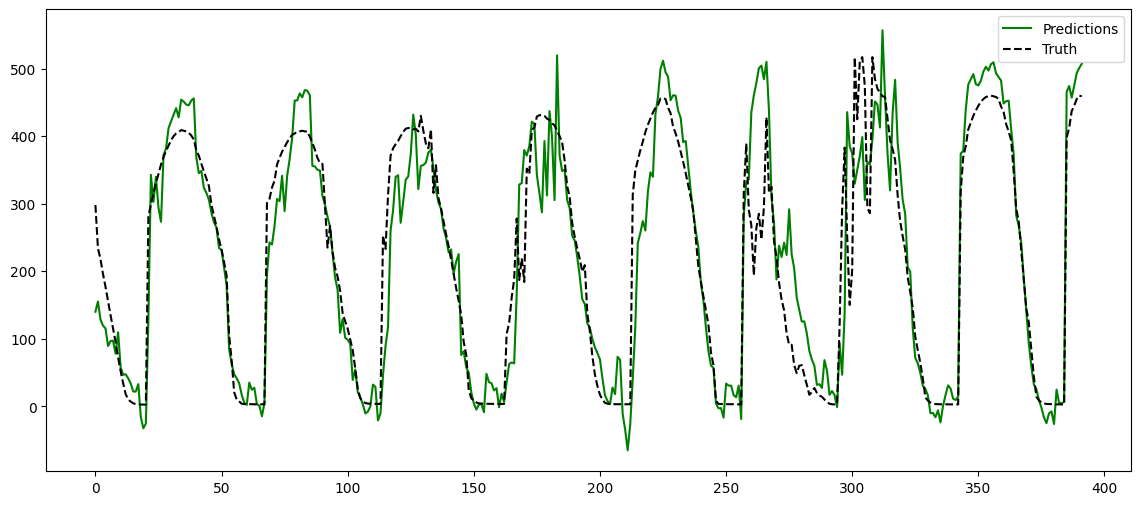

In [ ]:
test_loader = DataLoader(ghi_test, batch_sampler=SequentialBatchSampler2(np.arange(len(ghi_train)),L=4,batch_size=16))


pred = []
truth = []
test_loss = []
model.eval()
for data in test_loader:
  data = list(feature.to(device) for feature in data)
  target = data.pop()
  output = model(*data)

  pred.extend(output.tolist())
  truth.extend(target.tolist())
  test_loss.append(criterion(output, target[...,-1]).item())

Loss = np.mean(np.sqrt(test_loss))

print("the test loss is ",Loss)
#### a plot to visualize our predictions vs the true vlaues
plt.figure(figsize=(14,6))
plt.plot(pred, 'g', label = "Predictions")
plt.plot(truth, '--k',label = 'Truth')
plt.legend(loc = 'best')